In [1]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from helpers_barplot_intersection import reader_assign_conf_pep, plot_text, plot_intersection_bars

Matplotlib created a temporary config/cache directory at /scratch/slurm-job.3959809/matplotlib-6y7plvnn because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
# INPUTS 
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'
pipelines = ['OHSU', 'ETH']

FDR_limit = 0.05
MS_FDR = 'crux'
MS_strategy = 'pool' #Choice 'pool' 'joint', 'single' 
#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline


sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
    
    
# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
save = False

# Parse: results for all experiments

In [6]:
## Get peptides
samples_store_pep = {}
samples_store_rates = {}
experiment_pipelines_peptides =  defaultdict(dict)
experiments_pipelines_rates = defaultdict(dict)


for sample in all_samples:

    sample_short = '-'.join(sample.split('-')[0:3])
    samples_store_pep[sample] = experiment_pipelines_peptides
    samples_store_rates[sample] = experiments_pipelines_rates
    for pipeline in pipelines:
        path_single = os.path.join(proteomicsdir, pipeline, sample_short, 'assign_conf_per_experiment')
        path_pool_pipeline = os.path.join(proteomicsdir, pipeline, sample_short, 'assign_conf_pooled_FDR')
        path_pool_union = os.path.join(proteomicsdir, f'assign_conf_joint_to_{pipeline}', sample)
        
        path_test_OHSU = os.path.join(proteomicsdir, 'OHSU', sample_short, 'assign_conf_per_experiment')
        path_test_ETH = os.path.join(proteomicsdir, 'ETH', sample_short, 'assign_conf_per_experiment')
        experiment_list = [ i.split('/')[-1] for i in glob.glob(path_single + '/*')]

        for experiment in experiment_list:
            if pipeline == 'OHSU':
                original_name = experiment
                cut_name = experiment[1:]
            else:
                original_name = experiment
                cut_name = experiment
               
            if os.path.isfile(os.path.join(path_test_OHSU, 'J' + cut_name, 'assign-confidence.target.txt')) and \
                os.path.isfile(os.path.join(path_test_ETH, cut_name, 'assign-confidence.target.txt')): #Commun experiments
                
                
                # search 1 experiment, 1 pipeline  
                if MS_strategy == 'single':
                    df = os.path.join(path_single, original_name, 'assign-confidence.target.txt')
                # search all experiments, 1 pipeline
                if MS_strategy == 'pool':
                    df = os.path.join(path_pool_pipeline, f'tsearch-{original_name}.txt')
                # search all experiments, 1 union of pipelines
                if MS_strategy == 'joint':
                    df = os.path.join(path_pool_union, f'tsearch-{original_name}.txt')
                
                val, val_rate, peptides, _ = reader_assign_conf_pep(df, FDR_limit)
                samples_store_pep[sample][cut_name][pipeline] = peptides
                samples_store_rates[sample][cut_name][pipeline] = val_rate

                print('\n')


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR/tsearch-J0A53XGA.txt
With Shape: 1469
With unique peptides: 31
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR/tsearch-J0A13AGA.txt
With Shape: 9545
With unique peptides: 258
Number of validated psm: (12, 18)
Number of validated unique peptides: 4
Validation Rate: 1.55 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR/tsearch-J0A51XGA.txt
With Shape: 389
With unique peptides: 11
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR/tsearch-J0213XGA.txt
With Shape: 1511
With unique peptides: 38
Number of

With Shape: 42540
With unique peptides: 1134
Number of validated psm: (19, 18)
Number of validated unique peptides: 9
Validation Rate: 0.79 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR/tsearch-J02132GA.txt
With Shape: 1021
With unique peptides: 25
Number of validated psm: (9, 18)
Number of validated unique peptides: 1
Validation Rate: 4.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR/tsearch-J0211XGA.txt
With Shape: 712
With unique peptides: 14
Number of validated psm: (9, 18)
Number of validated unique peptides: 1
Validation Rate: 7.14 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR/tsearch-J0AN1XGA.txt
With Shape: 28548
With unique peptides: 757
Number of validated psm: (16, 18)
Number of validated unique peptides: 6
Validation Rate: 0.79 percent


Reading /cluster/work/grlab

With Shape: 25372
With unique peptides: 582
Number of validated psm: (149, 18)
Number of validated unique peptides: 9
Validation Rate: 1.55 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-AO-A0JM/assign_conf_pooled_FDR/tsearch-J0AN12GA.txt
With Shape: 17581
With unique peptides: 399
Number of validated psm: (144, 18)
Number of validated unique peptides: 6
Validation Rate: 1.5 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-AO-A0JM/assign_conf_pooled_FDR/tsearch-J0A11AGA.txt
With Shape: 1194
With unique peptides: 20
Number of validated psm: (2, 18)
Number of validated unique peptides: 1
Validation Rate: 5.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-AO-A0JM/assign_conf_pooled_FDR/tsearch-J0A101GA.txt
With Shape: 1057
With unique peptides: 19
Number of validated psm: (2, 18)
Number of validated unique peptides: 1
Validation Rate: 5.26 percent


Reading /cluster/work/grla

With Shape: 12154
With unique peptides: 418
Number of validated psm: (32, 18)
Number of validated unique peptides: 9
Validation Rate: 2.15 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-BH-A18V/assign_conf_pooled_FDR/tsearch-J0A532GA.txt
With Shape: 380
With unique peptides: 17
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-BH-A18V/assign_conf_pooled_FDR/tsearch-J0A11XGA.txt
With Shape: 1517
With unique peptides: 55
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-BH-A18V/assign_conf_pooled_FDR/tsearch-J0253XGA.txt
With Shape: 162
With unique peptides: 7
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/project

With Shape: 3810
With unique peptides: 69
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-BH-A18V/assign_conf_pooled_FDR/tsearch-0A532GA.txt
With Shape: 322
With unique peptides: 6
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-BH-A18V/assign_conf_pooled_FDR/tsearch-0A112GA.txt
With Shape: 578
With unique peptides: 7
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-BH-A18V/assign_conf_pooled_FDR/tsearch-0A53XGA.txt
With Shape: 667
With unique peptides: 16
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects20

With Shape: 182
With unique peptides: 5
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-A2-A0SX/assign_conf_pooled_FDR/tsearch-J0AN12GA.txt
With Shape: 10671
With unique peptides: 392
Number of validated psm: (20, 18)
Number of validated unique peptides: 5
Validation Rate: 1.28 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-A2-A0SX/assign_conf_pooled_FDR/tsearch-J0A11AGA.txt
With Shape: 1627
With unique peptides: 52
Number of validated psm: (7, 18)
Number of validated unique peptides: 2
Validation Rate: 3.85 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-A2-A0SX/assign_conf_pooled_FDR/tsearch-J0A101GA.txt
With Shape: 1608
With unique peptides: 50
Number of validated psm: (7, 18)
Number of validated unique peptides: 2
Validation Rate: 4.0 percent


Reading /cluster/work/grlab/proje

With Shape: 1085
With unique peptides: 29
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-A2-A0SX/assign_conf_pooled_FDR/tsearch-0A13XGA.txt
With Shape: 1012
With unique peptides: 20
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-A2-A0SX/assign_conf_pooled_FDR/tsearch-0A53AGA.txt
With Shape: 841
With unique peptides: 20
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-A2-A0SX/assign_conf_pooled_FDR/tsearch-0AN12GA.txt
With Shape: 551
With unique peptides: 18
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/project

With Shape: 112517
With unique peptides: 32403
Number of validated psm: (1379, 18)
Number of validated unique peptides: 611
Validation Rate: 1.89 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-25-1319/assign_conf_pooled_FDR/tsearch-J0A512GA.txt
With Shape: 28636
With unique peptides: 8276
Number of validated psm: (518, 18)
Number of validated unique peptides: 237
Validation Rate: 2.86 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-25-1319/assign_conf_pooled_FDR/tsearch-J0A112GA.txt
With Shape: 58931
With unique peptides: 17196
Number of validated psm: (810, 18)
Number of validated unique peptides: 395
Validation Rate: 2.3 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-25-1319/assign_conf_pooled_FDR/tsearch-J0AN1AGA.txt
With Shape: 103901
With unique peptides: 30140
Number of validated psm: (1160, 18)
Number of validated unique peptides: 552
Validation Rate: 1.83 percent


With Shape: 75636
With unique peptides: 4616
Number of validated psm: (267, 18)
Number of validated unique peptides: 87
Validation Rate: 1.88 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-25-1319/assign_conf_pooled_FDR/tsearch-02101GA.txt
With Shape: 48600
With unique peptides: 2968
Number of validated psm: (169, 18)
Number of validated unique peptides: 57
Validation Rate: 1.92 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-25-1319/assign_conf_pooled_FDR/tsearch-0A11XGA.txt
With Shape: 62054
With unique peptides: 3786
Number of validated psm: (197, 18)
Number of validated unique peptides: 69
Validation Rate: 1.82 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-25-1319/assign_conf_pooled_FDR/tsearch-02132GA.txt
With Shape: 59834
With unique peptides: 3665
Number of validated psm: (235, 18)
Number of validated unique peptides: 73
Validation Rate: 1.99 percent


Reading /clust

With Shape: 83999
With unique peptides: 14557
Number of validated psm: (962, 18)
Number of validated unique peptides: 366
Validation Rate: 2.51 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-25-1313/assign_conf_pooled_FDR/tsearch-J0A51AGA.txt
With Shape: 22263
With unique peptides: 3809
Number of validated psm: (374, 18)
Number of validated unique peptides: 126
Validation Rate: 3.31 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-25-1313/assign_conf_pooled_FDR/tsearch-J0AN12GA.txt
With Shape: 68566
With unique peptides: 12099
Number of validated psm: (716, 18)
Number of validated unique peptides: 283
Validation Rate: 2.34 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-25-1313/assign_conf_pooled_FDR/tsearch-J0A11AGA.txt
With Shape: 41982
With unique peptides: 7308
Number of validated psm: (567, 18)
Number of validated unique peptides: 213
Validation Rate: 2.91 percent


Re

With Shape: 45937
With unique peptides: 2142
Number of validated psm: (158, 18)
Number of validated unique peptides: 49
Validation Rate: 2.29 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-25-1313/assign_conf_pooled_FDR/tsearch-0A13AGA.txt
With Shape: 58695
With unique peptides: 2747
Number of validated psm: (217, 18)
Number of validated unique peptides: 70
Validation Rate: 2.55 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-25-1313/assign_conf_pooled_FDR/tsearch-0213XGA.txt
With Shape: 46436
With unique peptides: 2187
Number of validated psm: (163, 18)
Number of validated unique peptides: 55
Validation Rate: 2.51 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-25-1313/assign_conf_pooled_FDR/tsearch-0A501GA.txt
With Shape: 32274
With unique peptides: 1489
Number of validated psm: (134, 18)
Number of validated unique peptides: 36
Validation Rate: 2.42 percent


Reading /clust

With Shape: 46999
With unique peptides: 11654
Number of validated psm: (2658, 18)
Number of validated unique peptides: 545
Validation Rate: 4.68 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-J0A13AGA.txt
With Shape: 83009
With unique peptides: 21162
Number of validated psm: (3416, 18)
Number of validated unique peptides: 863
Validation Rate: 4.08 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-J0A51XGA.txt
With Shape: 31695
With unique peptides: 8080
Number of validated psm: (1478, 18)
Number of validated unique peptides: 350
Validation Rate: 4.33 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-J0213XGA.txt
With Shape: 31074
With unique peptides: 7592
Number of validated psm: (1851, 18)
Number of validated unique peptides: 349
Validation Rate: 4.6 percent



With Shape: 32024
With unique peptides: 7808
Number of validated psm: (1883, 18)
Number of validated unique peptides: 364
Validation Rate: 4.66 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-J0AN3XGA.txt
With Shape: 124892
With unique peptides: 33182
Number of validated psm: (4002, 18)
Number of validated unique peptides: 1147
Validation Rate: 3.46 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-J02132GA.txt
With Shape: 24447
With unique peptides: 6134
Number of validated psm: (1345, 18)
Number of validated unique peptides: 265
Validation Rate: 4.32 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-J0211XGA.txt
With Shape: 20232
With unique peptides: 5201
Number of validated psm: (874, 18)
Number of validated unique peptides: 222
Validation Rate: 4.27 percent


With Shape: 27011
With unique peptides: 1607
Number of validated psm: (385, 18)
Number of validated unique peptides: 41
Validation Rate: 2.55 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-0AN3XGA.txt
With Shape: 106887
With unique peptides: 6373
Number of validated psm: (1097, 18)
Number of validated unique peptides: 160
Validation Rate: 2.51 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-0A532GA.txt
With Shape: 70300
With unique peptides: 4172
Number of validated psm: (894, 18)
Number of validated unique peptides: 107
Validation Rate: 2.56 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-61-2008/assign_conf_pooled_FDR/tsearch-0A112GA.txt
With Shape: 70859
With unique peptides: 4251
Number of validated psm: (723, 18)
Number of validated unique peptides: 101
Validation Rate: 2.38 percent


Reading /

With Shape: 62690
With unique peptides: 10553
Number of validated psm: (1145, 18)
Number of validated unique peptides: 353
Validation Rate: 3.35 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-24-1431/assign_conf_pooled_FDR/tsearch-J0253AGA.txt
With Shape: 13106
With unique peptides: 2142
Number of validated psm: (308, 18)
Number of validated unique peptides: 93
Validation Rate: 4.34 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-24-1431/assign_conf_pooled_FDR/tsearch-J0251AGA.txt
With Shape: 7865
With unique peptides: 1283
Number of validated psm: (195, 18)
Number of validated unique peptides: 56
Validation Rate: 4.36 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-24-1431/assign_conf_pooled_FDR/tsearch-J02501GA.txt
With Shape: 7472
With unique peptides: 1220
Number of validated psm: (194, 18)
Number of validated unique peptides: 55
Validation Rate: 4.51 percent


Reading

With Shape: 33091
With unique peptides: 1431
Number of validated psm: (152, 18)
Number of validated unique peptides: 42
Validation Rate: 2.94 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-24-1431/assign_conf_pooled_FDR/tsearch-0A132GA.txt
With Shape: 53206
With unique peptides: 2300
Number of validated psm: (231, 18)
Number of validated unique peptides: 53
Validation Rate: 2.3 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-24-1431/assign_conf_pooled_FDR/tsearch-0213AGA.txt
With Shape: 57430
With unique peptides: 2506
Number of validated psm: (246, 18)
Number of validated unique peptides: 64
Validation Rate: 2.55 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-24-1431/assign_conf_pooled_FDR/tsearch-0A13XGA.txt
With Shape: 64586
With unique peptides: 2818
Number of validated psm: (291, 18)
Number of validated unique peptides: 71
Validation Rate: 2.52 percent


Reading /cluste

With Shape: 45035
With unique peptides: 14752
Number of validated psm: (1308, 18)
Number of validated unique peptides: 517
Validation Rate: 3.5 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-24-2298/assign_conf_pooled_FDR/tsearch-J0A501GA.txt
With Shape: 22263
With unique peptides: 7186
Number of validated psm: (794, 18)
Number of validated unique peptides: 302
Validation Rate: 4.2 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-24-2298/assign_conf_pooled_FDR/tsearch-J0211AGA.txt
With Shape: 15255
With unique peptides: 4932
Number of validated psm: (521, 18)
Number of validated unique peptides: 183
Validation Rate: 3.71 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/OHSU/TCGA-24-2298/assign_conf_pooled_FDR/tsearch-J02512GA.txt
With Shape: 6029
With unique peptides: 1932
Number of validated psm: (238, 18)
Number of validated unique peptides: 78
Validation Rate: 4.04 percent


Readin

With Shape: 58918
With unique peptides: 4304
Number of validated psm: (336, 18)
Number of validated unique peptides: 104
Validation Rate: 2.42 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-24-2298/assign_conf_pooled_FDR/tsearch-0AN01GA.txt
With Shape: 62311
With unique peptides: 4559
Number of validated psm: (355, 18)
Number of validated unique peptides: 109
Validation Rate: 2.39 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-24-2298/assign_conf_pooled_FDR/tsearch-0AN1XGA.txt
With Shape: 63913
With unique peptides: 4679
Number of validated psm: (359, 18)
Number of validated unique peptides: 111
Validation Rate: 2.37 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics/ETH/TCGA-24-2298/assign_conf_pooled_FDR/tsearch-0AN32GA.txt
With Shape: 73572
With unique peptides: 5417
Number of validated psm: (454, 18)
Number of validated unique peptides: 130
Validation Rate: 2.4 percent


Reading /cl

In [7]:
## Compare peptides

compare = {'sample' : [], 
          'filter_' : [], 
          'pep_size_ohsu' : [], 
          'pep_size_eth' : [], 
          'pep_size_intersection' : [], 
          'pep_size_ohsu\eth' : [], 
          'pep_size_eth\ohsu' : []}

for sample, experiments_ in samples_store_pep.items():
    for experiment, pipelines_ in experiments_.items():
        compare['sample'].append(sample)
        compare['filter_'].append(experiment)
        compare['pep_size_ohsu'].append(len(pipelines_['OHSU']))
        compare['pep_size_eth'].append(len(pipelines_['ETH']))
        compare['pep_size_ohsu\eth'].append(len(pipelines_['OHSU'].difference(pipelines_['ETH'])))
        compare['pep_size_eth\ohsu'].append(len(pipelines_['ETH'].difference(pipelines_['OHSU'])))
        compare['pep_size_intersection'].append(len(pipelines_['ETH'].intersection(pipelines_['ETH'])))

# Plot: Results per experiment

In [8]:
df = pd.DataFrame(compare)
display(df.head())
print(df.shape)

,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0A53XGA,450,127,127,351,28
1,TCGA-C8-A12P-01A-11R-A115-07,0A13AGA,723,152,152,592,21
2,TCGA-C8-A12P-01A-11R-A115-07,0A51XGA,315,86,86,247,18
3,TCGA-C8-A12P-01A-11R-A115-07,0213XGA,284,118,118,208,42
4,TCGA-C8-A12P-01A-11R-A115-07,0AN01GA,753,109,109,660,16


(350, 7)


In [15]:
def run_sample_plotting(sample_plot_dir, sample, df):
    order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')
    order_file = pd.read_csv(order_file, sep = '\t')
    display(order_file.head())
    print(order_file.shape)
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    display(df_plot.head())
    # Plotting
    run_type = run_type_plot_dir[sample]

    back_ticks = df_plot['filter_background'] 
    front_ticks = df_plot['filter_foreground']

    serie_index = df_plot['index']
    serie_intersection = df_plot['pep_size_intersection']
    serie_eth = df_plot['pep_size_eth']
    serie_ohsu = df_plot['pep_size_ohsu']
    y_label = 'Number of MS-detected tryptic junction-peptides'

    name_plot = 'Barplot_ovelap_protein_crux'
    base_plot = sample
    plot_dir = sample_plot_dir[sample]

    plot_intersection_bars(back_ticks, front_ticks, ticks_fontsize, axislabels_fontsize, 
                              legend_fontsize, axes_fontsize, run_type, 
                               serie_index, serie_intersection, serie_eth, serie_ohsu,
                               y_label, save, plot_dir, base_plot, name_plot)

,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,filter_foreground_samples,filter_background_reads,filter_background_samples,cohort,motif,index,filter_background,filter_foreground
0,7,TCGA-25-1319-01A-01R-1565-13,02501GA,23972,20052,8874,15098,11178,0,2,5,0,1,G,A,0,"(0, 1)","(0, 2, 5)"
1,30,TCGA-25-1319-01A-01R-1565-13,02512GA,24766,20638,9166,15600,11472,0,2,5,1,2,G,A,1,"(1, 2)","(0, 2, 5)"
2,14,TCGA-25-1319-01A-01R-1565-13,0251AGA,24913,20683,9193,15720,11490,0,2,5,1,A,G,A,2,"(1, A)","(0, 2, 5)"
3,8,TCGA-25-1319-01A-01R-1565-13,0251XGA,24913,20683,9193,15720,11490,0,2,5,1,X,G,A,3,"(1, X)","(0, 2, 5)"
4,15,TCGA-25-1319-01A-01R-1565-13,02532GA,29573,24940,11086,18487,13854,0,2,5,3,2,G,A,4,"(3, 2)","(0, 2, 5)"


(35, 18)
(35, 23)


,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,...,cohort,motif,index,filter_background,filter_foreground,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,7,TCGA-25-1319-01A-01R-1565-13,02501GA,23972,20052,8874,15098,11178,0,2,...,G,A,0,"(0, 1)","(0, 2, 5)",76,37,37,49,10
1,30,TCGA-25-1319-01A-01R-1565-13,02512GA,24766,20638,9166,15600,11472,0,2,...,G,A,1,"(1, 2)","(0, 2, 5)",78,38,38,51,11
2,14,TCGA-25-1319-01A-01R-1565-13,0251AGA,24913,20683,9193,15720,11490,0,2,...,G,A,2,"(1, A)","(0, 2, 5)",78,38,38,51,11
3,8,TCGA-25-1319-01A-01R-1565-13,0251XGA,24913,20683,9193,15720,11490,0,2,...,G,A,3,"(1, X)","(0, 2, 5)",78,38,38,51,11
4,15,TCGA-25-1319-01A-01R-1565-13,02532GA,29573,24940,11086,18487,13854,0,2,...,G,A,4,"(3, 2)","(0, 2, 5)",96,51,51,59,14


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_ovelap_protein_crux.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:91: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


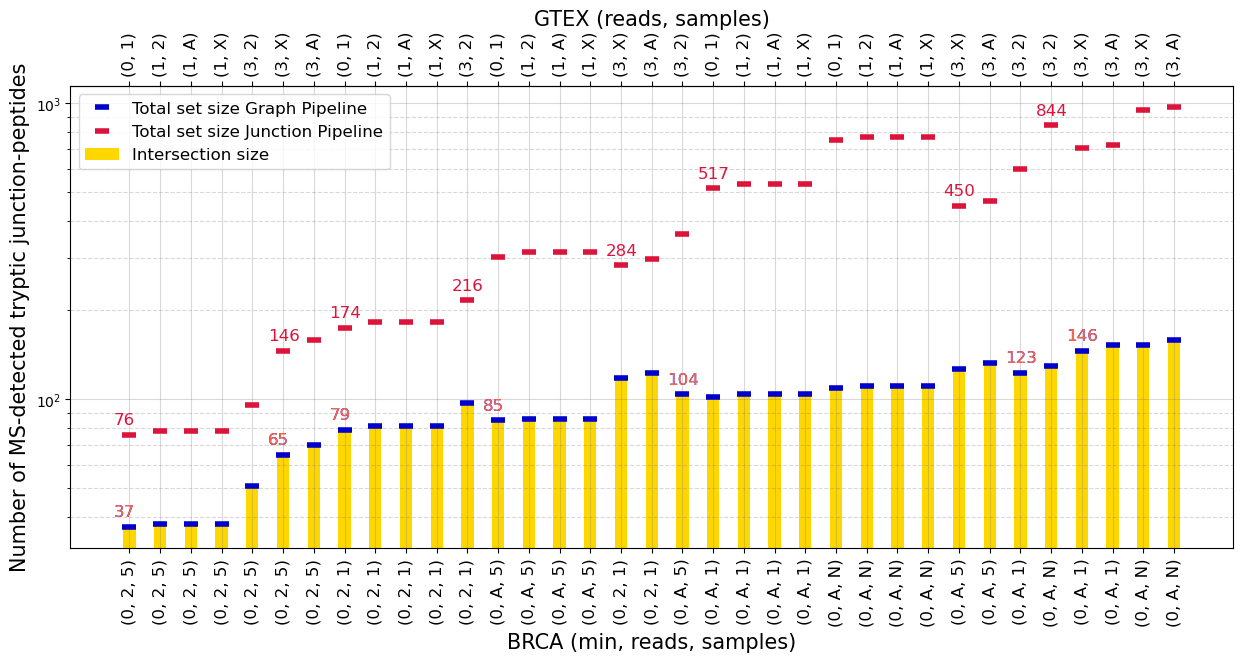

In [16]:
for sample in all_samples:
    run_sample_plotting(sample_plot_dir, sample, df)